No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


LOO, bestK = 14, error = 51


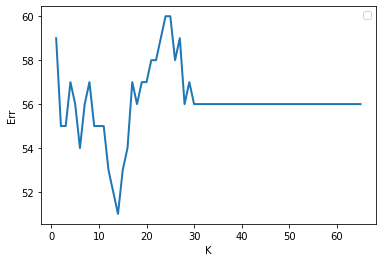

Score model for Dynamic Parzen method


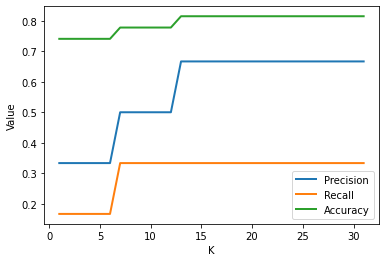

Score model for Fixed Parzen method


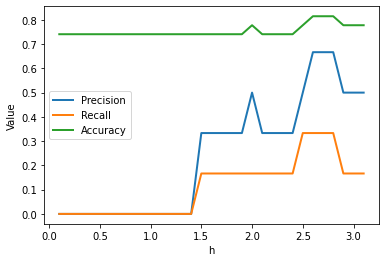

Score model for naive KNN method


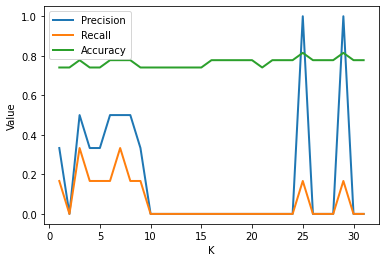

Score SKKLEARN


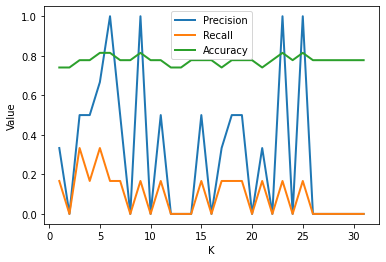

Score SKKLEARN
------For weighted point------


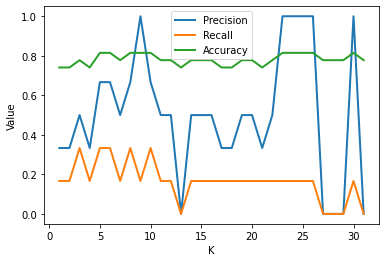

end


In [56]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import random
import numpy
import math
#fix categorial
def defaultDummies(dataSet, col):
    return pd.get_dummies(dataSet, columns = col)
#show LOO graph(x = knear, y = deltaError)
def showLOOGraph(values):
    x = []
    for i in range(len(values)):
        x.append(i+1)
    plt.xlabel('K')
    plt.ylabel('Err')
    plt.legend()
    plt.plot(x, values, linewidth=2.0)
    plt.show()
#LOO CV
def LOO(trainData, trainY):
    
    n = math.ceil(math.sqrt(trainData.shape[0]))+50
    deltaError = 0
    deltaErrorLst = []
    for k in range(1, n):
        deltaError = 0
        for i in range(len(trainData)):
            dataSetWithoutOne = trainData.drop(i, axis = 0)
            yWithoutOne = trainY.drop(i, axis = 0)
            yOld = trainY.take([i]).to_numpy()[0][0]
            yPredict = naiveKNN(k, trainData.take([i]).to_numpy(), dataSetWithoutOne.to_numpy(), yWithoutOne[9].to_numpy())
            if(yPredict != yOld):
                deltaError += 1;
        deltaErrorLst.append(deltaError)
    
    indices = sorted(range(len(deltaErrorLst)), key=lambda i: deltaErrorLst[i])
    
    bestK = indices[0]+1
    bestDeltaError = deltaErrorLst[indices[0]]

    return [deltaErrorLst, bestK, bestDeltaError]
    
def showGraph(values1, values2, values3, param="K"):
    dels = 0
    x = []
    for i in range(len(values1)):
        if(param=="K"):
            x.append((i+1))
        else:
            x.append((i+1)/10)
    plt.plot(x, values1, linewidth=2.0, label="Precision")
    plt.plot(x, values2, linewidth=2.0, label="Recall")
    plt.plot(x, values3, linewidth=2.0, label="Accuracy")
    plt.xlabel(param)
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def sklearnKNN(trainData, trainY, testData, testY, isWeighted = False):
    n = math.ceil(math.sqrt(trainData.shape[0]))*2
    
    trainData = trainData.values.tolist()
    testData = testData.values.tolist()
    
    trainY = trainY[9].values.tolist()
    truthY = testY[9].values.tolist()
    
    scores = []
    precisions = []
    recalls = []
    for i in range(1,n):
        if(isWeighted):
            neigh = KNeighborsClassifier(n_neighbors=i, weights="distance")
        else:
            neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(trainData, trainY)
        scores.append(neigh.score(testData,truthY))
        yPred = neigh.predict(testData)
        
        precisions.append(precision_score(truthY, yPred, pos_label="yes", zero_division = 0))
        recalls.append(recall_score(truthY, yPred, pos_label="yes", zero_division = 0))
    print(f'Score SKKLEARN')
    if(isWeighted):
        print("------For weighted point------")
    showGraph(precisions, recalls, scores)
    

#mode = {2, 1, 0} 2-parzenWindowKNNDynamic, 1 - parzenWindowKNNFixed, 0 - naiveKNN
def testKNN(trainData, trainY, testData, mode):
    n = math.ceil(math.sqrt(trainData.shape[0]))*2
    fullYPredicts = []
    for k in range(1, n):
        Y = []
        for i in range(len(testData)):
            if(mode == 2):
                yPredict = parzenWindowKNN(k, testData.take([i]).to_numpy(), trainData.to_numpy(), trainY[9].to_numpy())
            elif(mode == 1):
                yPredict = parzenWindowFixedKNN(k/10, testData.take([i]).to_numpy(), trainData.to_numpy(), trainY[9].to_numpy())
            else:
                yPredict = naiveKNN(k, testData.take([i]).to_numpy(), trainData.to_numpy(), trainY[9].to_numpy())
            Y.append(yPredict)
        fullYPredicts.append(Y)
    return fullYPredicts
#distance euclide
def dist(point_1, point_2):
    square = numpy.square(point_1 - point_2)
    sum_square = numpy.sum(square)
    distance = numpy.sqrt(sum_square)
    return distance
#coeeff determination
def scoreModel(allAnswers, truthY):
    truthAnswer = truthY[9].to_list()
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    precisions = []
    recalls = []
    accuracys = []
    for i in range(len(allAnswers)):
        for j in range(len(allAnswers[i])):
            currentAnswer = allAnswers[i][j]
            if((truthAnswer[j] == currentAnswer) and truthAnswer[j] == "yes"):
                TP += 1
            if((truthAnswer[j] == currentAnswer) and truthAnswer[j] == "no"):
                TN += 1
            if((truthAnswer[j] != currentAnswer) and truthAnswer[j] == "yes"):
                FN += 1
            if((truthAnswer[j] != currentAnswer) and truthAnswer[j] == "no"):
                FP += 1
        if(TP+FP == 0):
            precision = 0
        else:
            precision = TP/(TP+FP)
        if(TP+FN == 0):
            recall = 0
        else:
            recall = TP/(TP+FN)
        if(TP + TN + FP + FN == 0):
            accuracy = 0
        else:
            accuracy = (TP + TN)/(TP + TN + FP + FN)
        TP = 0
        TN = 0
        FN = 0
        FP = 0
        precisions.append(precision)
        recalls.append(recall)
        accuracys.append(accuracy)
    return [precisions, recalls, accuracys]
                
def parzenWindowFixedKNN(h, testElem, trainData, trainY):
    n = trainData.shape[0]
    dists = []
    inWindow = False
    for i in range(n):
        currentTrainElem = trainData[i]
        lng = dist(currentTrainElem, testElem)
        if(lng <= h):
            dists.append(lng/h)
            inWindow = True
        else:
            dists.append(math.inf)
    yPredict = {}
    yPredict["yes"] = 0
    yPredict["no"] = 0

    for i in range(len(dists)):
        if(dists[i] < math.inf):
            coeff = 1 - dists[i]
            yPredict[trainY[i]] += coeff * 1
    if(inWindow):
        return "yes" if yPredict["yes"] > yPredict["no"] else "no"
    else:
        return naiveKNN(14, testElem, trainData, trainY)
    
def parzenWindowKNN(k, testElem, trainData, trainY):
    n = trainData.shape[0]
    dists = []
    for i in range(n):
        currentTrainElem = trainData[i]
        lng = dist(currentTrainElem, testElem)
        dists.append(lng)
    indices = sorted(range(len(dists)), key=lambda i: dists[i])
    
    h = dists[indices[k]]
        
    yPredict = {}
    yPredict["yes"] = 0
    yPredict["no"] = 0
    for i in range(k):
        if(h != 0):
            coeff = (1 - (dists[indices[i]]/h))
            yPredict[trainY[indices[i]]] += coeff * 1
        else:
            yPredict[trainY[indices[i]]] += 1
    #return yPredict/k if h == 0 else yPredict
    return "yes" if yPredict["yes"] > yPredict["no"] else "no"
    
def naiveKNN(k, testElem, trainData, trainY):
    yNear = {}
    dists = []
    
    n = trainData.shape[0]

    for i in range(n):
        currentTrainElem = trainData[i]
        lng = dist(currentTrainElem, testElem)
        dists.append(lng)
    
    indices = sorted(range(len(dists)), key=lambda i: dists[i])
    
    yNear["yes"] = 0
    yNear["no"] = 0
    for i in range(k):
        yNear[trainY[indices[i]]] += 1;
    return "yes" if yNear["yes"] > yNear["no"] else "no"


def readData():
    data = pd.read_csv("./breast-cancer.data", header = None, sep = ",")
    
    
    data.dropna(axis=0,inplace=True) 
    data = defaultDummies(data, [0,1,2,3,4,5,6,7,8])
    data = data.reset_index(drop=True)
    
    trainData = data.iloc[:250,:]
    testData = data.iloc[250:,:]

    trainY = trainData[[9]]
    testY = testData[[9]]
    
    trainData = trainData.drop([9], axis=1)
    testData = testData.drop([9], axis=1)
    
    #trainData = trainData.reset_index(drop=True)
    #trainY = trainY.reset_index(drop=True)
    
    return [trainData, testData, trainY, testY]



    


    

def main():
    trainData, testData, trainY, testY = readData()
    #LOO
    deltaErrorLst, bestK, bestDeltaError = LOO(trainData, trainY)
    print(f'LOO, bestK = {bestK}, error = {bestDeltaError}')
    showLOOGraph(deltaErrorLst)
    print("Score model for Dynamic Parzen method")
    forYDynamic = testKNN(trainData, trainY, testData, 2)
    precisoins1, recalls1, accuracys1 = scoreModel(forYDynamic, testY)
    showGraph(precisoins1, recalls1, accuracys1)
    print("Score model for Fixed Parzen method")
    forYFixed = testKNN(trainData, trainY, testData, 1)
    precisoins2, recalls2, accuracys2 = scoreModel(forYFixed, testY)
    showGraph(precisoins2, recalls2, accuracys2,  "h")
    print("Score model for naive KNN method")
    forYNaive = testKNN(trainData, trainY, testData, 0)
    precisoins3, recalls3, accuracys3 = scoreModel(forYNaive, testY)
    showGraph(precisoins3, recalls3, accuracys3)
    
    
    sklearnKNN(trainData, trainY, testData, testY)
    sklearnKNN(trainData, trainY, testData, testY, True)
    
    print("end")
    


main()
